In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE

import seaborn as sns

from utils import print_permutation_importances, print_accuracy, fit_and_rank, get_topK, preprocessing_column_transformer, attrition_flag_map, calc_shap_overall_diff

# Data analysis

In [158]:
seed = 42

torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
cuda = torch.cuda.is_available()
if cuda is True:
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [159]:
path = "data/credit_card_churn.csv"

In [160]:
df = pd.read_csv(path)

In [161]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [162]:
df[["Total_Trans_Amt", "Total_Revolving_Bal", "Total_Relationship_Count", "Total_Ct_Chng_Q4_Q1", "Months_Inactive_12_mon"]].min()


Total_Trans_Amt             510.0
Total_Revolving_Bal           0.0
Total_Relationship_Count      1.0
Total_Ct_Chng_Q4_Q1           0.0
Months_Inactive_12_mon        0.0
dtype: float64

In [163]:
df[["Total_Trans_Amt", "Total_Revolving_Bal", "Total_Relationship_Count", "Total_Ct_Chng_Q4_Q1", "Months_Inactive_12_mon"]].max()

Total_Trans_Amt             18484.000
Total_Revolving_Bal          2517.000
Total_Relationship_Count        6.000
Total_Ct_Chng_Q4_Q1             3.714
Months_Inactive_12_mon          6.000
dtype: float64

In [164]:
print("null: \n", df.isna().sum())


null: 
 CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                         

In [165]:
print("duplicates: ", df.duplicated(keep=False).sum())
print("imbalance count: \n", df['Attrition_Flag'].value_counts())
print("\nimbalance ratio:\n", df['Attrition_Flag'].value_counts(normalize=True))
print(len(df.columns))

duplicates:  0
imbalance count: 
 Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64

imbalance ratio:
 Attrition_Flag
Existing Customer    0.83934
Attrited Customer    0.16066
Name: proportion, dtype: float64
23


In [166]:
df["Attrition_Flag"].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

# Preprocessing

In [167]:
df["Attrition_Flag"] = attrition_flag_map(df)

In [168]:
df.drop(["Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
		"Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2", 
		"CLIENTNUM"],
		axis=1, inplace=True)

In [169]:
y = df['Attrition_Flag']
x = df.drop(columns=["Attrition_Flag"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y, shuffle=True)

In [ ]:
preprocessing_pipe = preprocessing_column_transformer()

In [171]:
preprocessing_pipe.fit(x_train, y_train)

ColumnTransformer(transformers=[('cat_onehot', OneHotEncoder(),
                                 ['Gender', 'Marital_Status']),
                                ('scale', StandardScaler(),
                                 ['Customer_Age', 'Dependent_count',
                                  'Months_on_book', 'Total_Relationship_Count',
                                  'Months_Inactive_12_mon',
                                  'Contacts_Count_12_mon', 'Credit_Limit',
                                  'Total_Revolving_Bal', 'Avg_Open_To_Buy',
                                  'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                                  'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
                                  'Avg_Utilization_Ratio']),
                                ('ord_enc',
                                 OrdinalEncoder(categories=[['Unknown',
                                                             'Uneducated',
                                                             'High School',
                                                             'Graduate',
                                                             'College',
                                                             'Doctorate',
                                                             'Post-Graduate'],
                                                            ['Unknown',
                                                             'Less than $40K',
                                                             '$40K - $60K',
                                                             '$60K - $80K',
                                                             '$80K - $120K',
                                                             '$120K +'],
                                                            ['Blue', 'Silver',
                                                             'Gold',
                                                             'Platinum']]),
                                 ['Education_Level', 'Income_Category',
                                  'Card_Category'])])

In [172]:
feature_names = preprocessing_pipe.get_feature_names_out()

x_train_enc_arr = preprocessing_pipe.transform(x_train)
x_train_enc = pd.DataFrame(x_train_enc_arr, columns=feature_names, index=x_train.index)

x_test_enc_arr = preprocessing_pipe.transform(x_test)
x_test_enc = pd.DataFrame(x_test_enc_arr, columns=feature_names, index=x_test.index)

In [173]:
x_train_enc.columns = [col.split('__')[-1] for col in x_train_enc.columns]
x_test_enc.columns = [col.split('__')[-1] for col in x_test_enc.columns]

In [174]:
# Drop features that have reduntant information based on other features
x_train_enc.drop(columns=["Marital_Status_Unknown", "Gender_M"], inplace=True)
x_test_enc.drop(columns=["Marital_Status_Unknown", "Gender_M"], inplace=True)

In [175]:
smote = SMOTE(random_state=seed)
x_train_enc, y_train = smote.fit_resample(x_train_enc, y_train)

In [176]:
print("\nimbalance ratio:\n", y_train.value_counts(normalize=True))


imbalance ratio:
 Attrition_Flag
0    0.5
1    0.5
Name: proportion, dtype: float64


In [177]:
# Correlation matrix
corr_data = x_train_enc.copy()
corr_data["y"] = y_train
correlation_matrix = corr_data.corr()

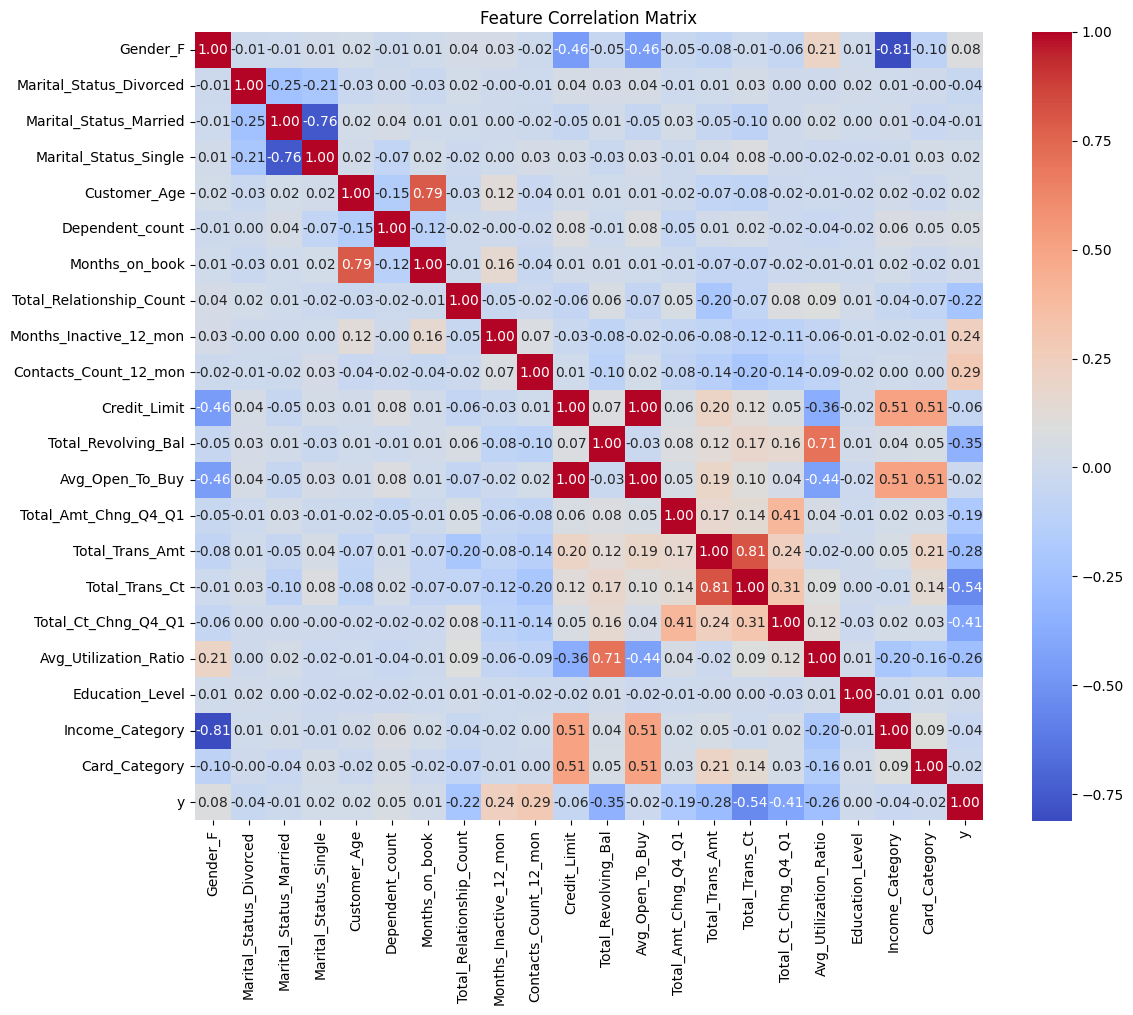

In [178]:
# Compute correlation matrix
correlation_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("pictures/corr_matrix.png")
plt.show()

In [179]:
x_train_enc.drop(columns=["Avg_Open_To_Buy", "Customer_Age", "Total_Trans_Ct", "Avg_Utilization_Ratio"], inplace=True)
x_test_enc.drop(columns=["Avg_Open_To_Buy", "Customer_Age", "Total_Trans_Ct", "Avg_Utilization_Ratio"], inplace=True)

In [180]:
rf_model = RandomForestClassifier(random_state=seed, max_depth=8)

In [181]:
rf_model.fit(x_train_enc, y_train)
y_pred = rf_model.predict(x_test_enc)

In [182]:
print_accuracy(rf_model, x_train_enc, y_train, x_test_enc, y_test, y_pred)

Train accuracy: 0.9652154728636564
Test accuracy: 0.9244817374136229
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1701
           1       0.75      0.80      0.77       325

    accuracy                           0.92      2026
   macro avg       0.85      0.87      0.86      2026
weighted avg       0.93      0.92      0.93      2026



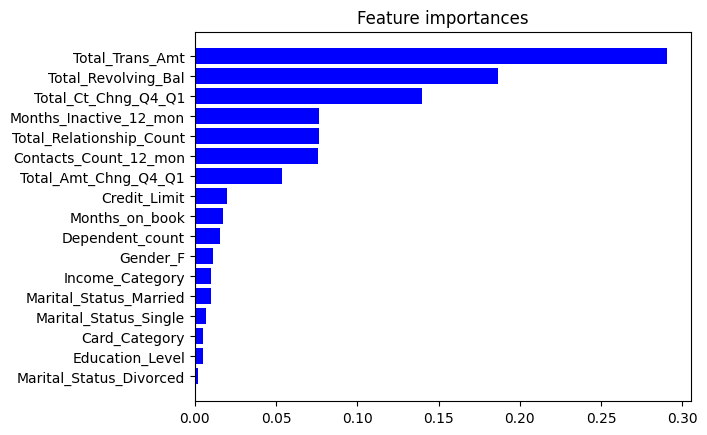

In [183]:
feature_importance = rf_model.feature_importances_
feature_names = x_train_enc.columns

sorted_idx = feature_importance.argsort()

#Plot the feature importance
plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx], color='blue')
plt.title("Feature importances")
plt.savefig("pictures/feat_importances.png")  # high quality
plt.show()

In [184]:
perm_imp_train = permutation_importance(rf_model, x_train_enc, y_train, n_repeats=10, random_state=seed)
perm_imp_test = permutation_importance(rf_model, x_test_enc, y_test, n_repeats=10, random_state=seed)

Train permutation importance 
- Gender_F => Mean: 0.0042 ; Std: 0.0005
- Marital_Status_Divorced => Mean: 0.0004 ; Std: 0.0001
- Marital_Status_Married => Mean: 0.0030 ; Std: 0.0007
- Marital_Status_Single => Mean: 0.0018 ; Std: 0.0004
- Dependent_count => Mean: 0.0053 ; Std: 0.0004
- Months_on_book => Mean: 0.0074 ; Std: 0.0006
- Total_Relationship_Count => Mean: 0.0436 ; Std: 0.0014
- Months_Inactive_12_mon => Mean: 0.0276 ; Std: 0.0011
- Contacts_Count_12_mon => Mean: 0.0145 ; Std: 0.0009
- Credit_Limit => Mean: 0.0104 ; Std: 0.0006
- Total_Revolving_Bal => Mean: 0.0542 ; Std: 0.0019
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0175 ; Std: 0.0012
- Total_Trans_Amt => Mean: 0.1780 ; Std: 0.0039
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0303 ; Std: 0.0012
- Education_Level => Mean: 0.0016 ; Std: 0.0002
- Income_Category => Mean: 0.0027 ; Std: 0.0005
- Card_Category => Mean: 0.0019 ; Std: 0.0001

 Test permutation importance
- Gender_F => Mean: 0.0017 ; Std: 0.0016
- Marital_Status_Divorced => Mean: -0.00

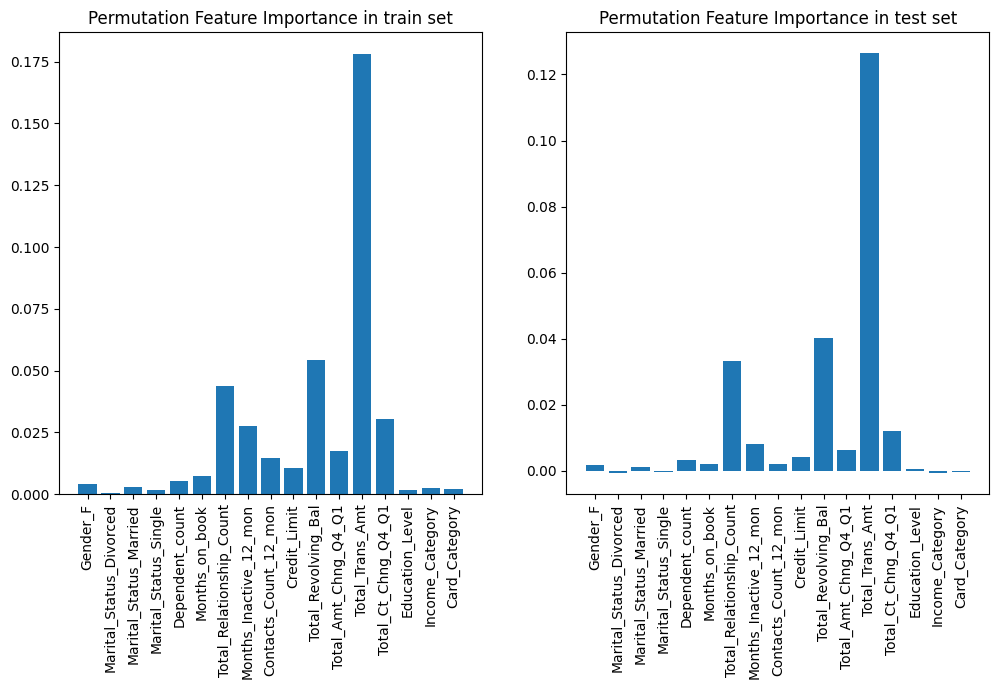

In [185]:
print_permutation_importances(perm_imp_train, perm_imp_test, x_train_enc.columns, plot=True)

In [186]:
# Removing the 6 least important features
x_train_enc.drop(columns=["Marital_Status_Single", "Marital_Status_Married", "Marital_Status_Divorced", "Education_Level", "Card_Category", "Income_Category"], inplace=True)
x_test_enc.drop(columns=["Marital_Status_Single", "Marital_Status_Married", "Marital_Status_Divorced", "Education_Level", "Card_Category", "Income_Category"], inplace=True)

# Fit new data and rank

Train accuracy: 0.9608030592734226
Test accuracy: 0.9254689042448174
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1701
           1       0.75      0.81      0.78       325

    accuracy                           0.93      2026
   macro avg       0.85      0.88      0.87      2026
weighted avg       0.93      0.93      0.93      2026

Train permutation importance 
- Gender_F => Mean: 0.0053 ; Std: 0.0006
- Dependent_count => Mean: 0.0033 ; Std: 0.0005
- Months_on_book => Mean: 0.0073 ; Std: 0.0004
- Total_Relationship_Count => Mean: 0.0455 ; Std: 0.0017
- Months_Inactive_12_mon => Mean: 0.0289 ; Std: 0.0009
- Contacts_Count_12_mon => Mean: 0.0149 ; Std: 0.0011
- Credit_Limit => Mean: 0.0127 ; Std: 0.0010
- Total_Revolving_Bal => Mean: 0.0583 ; Std: 0.0020
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0175 ; Std: 0.0005
- Total_Trans_Amt => Mean: 0.1849 ; Std: 0.0036
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0331 ; Std: 0.0015

 Test permutation imp

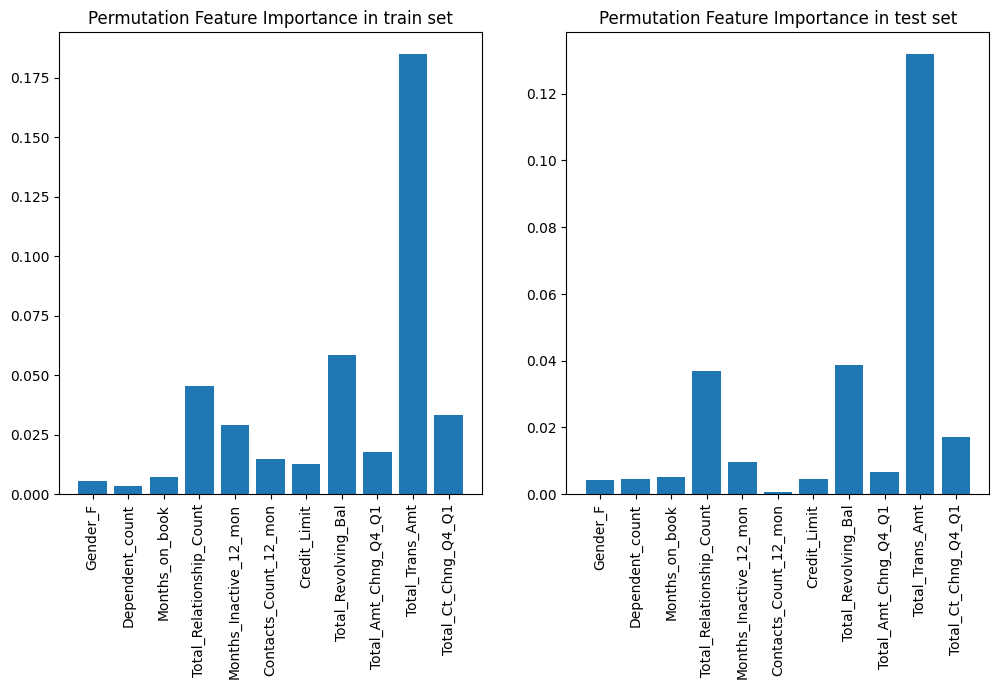

In [187]:
ranking, probs, y_pred = fit_and_rank(rf_model, x_train_enc, y_train, x_test_enc, y_test, "pictures/perm_imp2.png")

In [188]:
k = 50
topk_df = get_topK(x_test, y_test, y_pred, ranking, probs, k)

In [189]:
topk_df.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,true_label,pred_label,pred_prob
6244,45,F,2,College,Single,Less than $40K,Blue,33,1,3,...,0,1833.0,0.549,2037,31,0.292,0.0,1,1,0.990295
8084,56,F,3,Unknown,Single,Less than $40K,Blue,39,1,3,...,0,1632.0,0.621,2509,47,0.424,0.0,1,1,0.990167
3811,49,F,3,Graduate,Single,Unknown,Blue,31,2,3,...,0,4946.0,0.540,2239,38,0.407,0.0,1,1,0.989598
8186,44,F,1,High School,Single,Less than $40K,Blue,36,2,3,...,0,1895.0,0.736,2472,40,0.429,0.0,1,1,0.988298
5925,55,F,2,Graduate,Divorced,Less than $40K,Blue,50,2,6,...,0,1720.0,0.707,2719,36,0.440,0.0,1,1,0.987762


In [190]:
topk_df.iloc[0]

Customer_Age                            45
Gender                                   F
Dependent_count                          2
Education_Level                    College
Marital_Status                      Single
Income_Category             Less than $40K
Card_Category                         Blue
Months_on_book                          33
Total_Relationship_Count                 1
Months_Inactive_12_mon                   3
Contacts_Count_12_mon                    3
Credit_Limit                        1833.0
Total_Revolving_Bal                      0
Avg_Open_To_Buy                     1833.0
Total_Amt_Chng_Q4_Q1                 0.549
Total_Trans_Amt                       2037
Total_Trans_Ct                          31
Total_Ct_Chng_Q4_Q1                  0.292
Avg_Utilization_Ratio                  0.0
true_label                               1
pred_label                               1
pred_prob                         0.990295
Name: 6244, dtype: object

In [191]:
topk_df.iloc[49]

Customer_Age                            34
Gender                                   F
Dependent_count                          4
Education_Level                   Graduate
Marital_Status                     Married
Income_Category             Less than $40K
Card_Category                         Blue
Months_on_book                          36
Total_Relationship_Count                 2
Months_Inactive_12_mon                   2
Contacts_Count_12_mon                    4
Credit_Limit                        5021.0
Total_Revolving_Bal                   2517
Avg_Open_To_Buy                     2504.0
Total_Amt_Chng_Q4_Q1                 0.587
Total_Trans_Amt                       2270
Total_Trans_Ct                          40
Total_Ct_Chng_Q4_Q1                  0.481
Avg_Utilization_Ratio                0.501
true_label                               1
pred_label                               1
pred_prob                         0.952058
Name: 7461, dtype: object

In [192]:
original_index_sample1 = int(topk_df.index[0])
original_index_sample2 = int(topk_df.index[49])

# Experiments

In [193]:
# based on perm_imp2
top_5_feat = ["Total_Trans_Amt", "Total_Revolving_Bal", "Total_Relationship_Count", "Total_Ct_Chng_Q4_Q1", "Months_Inactive_12_mon"]

## Experiment 1
Pick 2 samples **a** and **b** from the test data and iteratively change one of the feature values in **b** to the one in **a** and see how the ranking changes. 

In [194]:
id_instance_1 = ranking[0]
id_instance_2 = ranking[49]

In [195]:
probabilities = []
pre_prob = float(rf_model.predict_proba(x_test_enc.iloc[id_instance_2].copy().to_frame().T)[0, 1])

# checks how the probability of sample2 changes when we sample from sample 1, one feature at a time
for col in top_5_feat:
	sample1 =  x_test_enc.iloc[id_instance_1].copy()
	sample2 = x_test_enc.iloc[id_instance_2].copy()

	sample2[col] = sample1[col]
	prob = float(rf_model.predict_proba(sample2.to_frame().T)[0, 1])
	probabilities.append((col, prob))

probabilities

[('Total_Trans_Amt', 0.9485901052355656),
 ('Total_Revolving_Bal', 0.9813571505040144),
 ('Total_Relationship_Count', 0.9524475495548778),
 ('Total_Ct_Chng_Q4_Q1', 0.9569948653209732),
 ('Months_Inactive_12_mon', 0.9657658768082635)]

[-0.003467599649531361, 0.029299445618917397, 0.00038984466978075893, 0.00493716043587622, 0.013708171923166534]


/var/folders/dz/r23r91c54xn18t6mjccp7qz40000gn/T/ipykernel_29659/2768633868.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


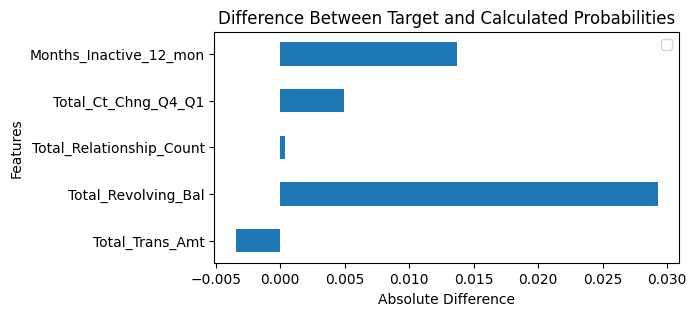

In [196]:
# Differences
probs = [float(p[1]) for p in probabilities]
labels = [p[0] for p in probabilities]
differences = [p - pre_prob for p in probs]
print(differences)

# Plot
plt.figure(figsize=[6, 3])
plt.barh(range(len(probs)), differences, height=0.5)
plt.title('Difference Between Target and Calculated Probabilities')
plt.ylabel('Features')
plt.yticks(range(len(probs)), labels, rotation=0)
plt.xlabel('Absolute Difference')
plt.legend()
plt.savefig("pictures/exp1.png")
plt.show()

## Experiment 2
Drop one feature at a time and see how the ranking changes

PermutationExplainer explainer: 2027it [06:53,  4.79it/s]                          


Train accuracy: 0.9268274746286218
Test accuracy: 0.8721618953603159
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1701
           1       0.59      0.69      0.63       325

    accuracy                           0.87      2026
   macro avg       0.76      0.80      0.78      2026
weighted avg       0.88      0.87      0.88      2026

Train permutation importance 
- Gender_F => Mean: 0.0045 ; Std: 0.0008
- Dependent_count => Mean: 0.0051 ; Std: 0.0007
- Months_on_book => Mean: 0.0088 ; Std: 0.0005
- Total_Relationship_Count => Mean: 0.0421 ; Std: 0.0015
- Months_Inactive_12_mon => Mean: 0.0834 ; Std: 0.0019
- Contacts_Count_12_mon => Mean: 0.0739 ; Std: 0.0020
- Credit_Limit => Mean: 0.0085 ; Std: 0.0006
- Total_Revolving_Bal => Mean: 0.1025 ; Std: 0.0026
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0076 ; Std: 0.0007
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0862 ; Std: 0.0013

 Test permutation importance
- Gender_F => Mean: 0.0035 ; Std: 0.0014

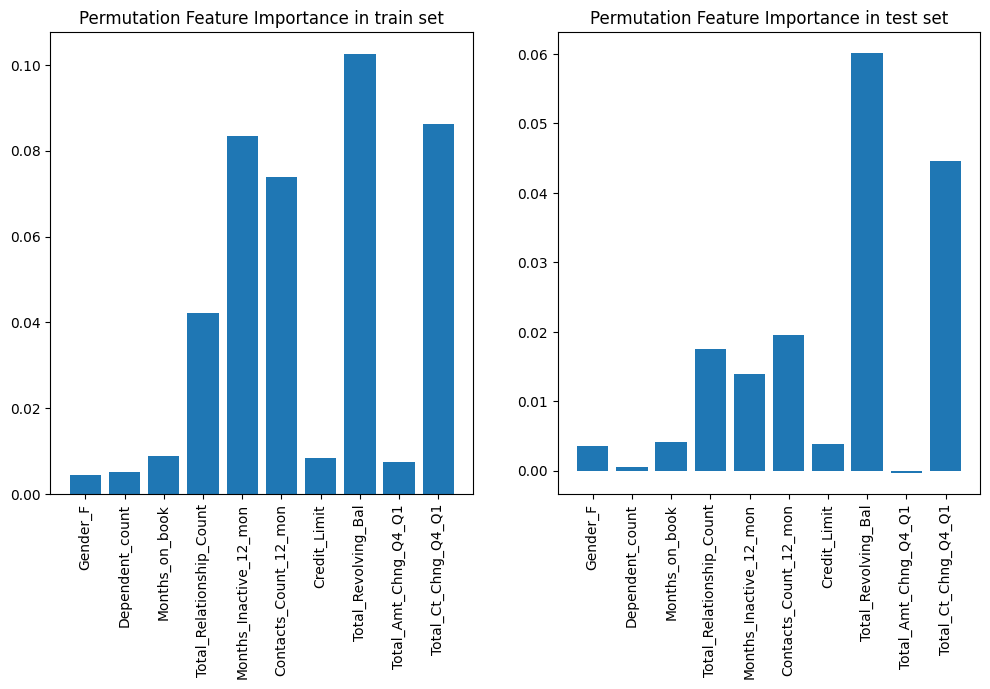

ExactExplainer explainer: 2027it [07:45,  4.27it/s]                          


Train accuracy: 0.9532284159435211
Test accuracy: 0.9146100691016782
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1701
           1       0.70      0.81      0.75       325

    accuracy                           0.91      2026
   macro avg       0.83      0.87      0.85      2026
weighted avg       0.92      0.91      0.92      2026

Train permutation importance 
- Gender_F => Mean: 0.0084 ; Std: 0.0007
- Dependent_count => Mean: 0.0058 ; Std: 0.0004
- Months_on_book => Mean: 0.0091 ; Std: 0.0004
- Total_Relationship_Count => Mean: 0.0517 ; Std: 0.0011
- Months_Inactive_12_mon => Mean: 0.0482 ; Std: 0.0013
- Contacts_Count_12_mon => Mean: 0.0275 ; Std: 0.0015
- Credit_Limit => Mean: 0.0135 ; Std: 0.0004
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0220 ; Std: 0.0007
- Total_Trans_Amt => Mean: 0.2111 ; Std: 0.0028
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0524 ; Std: 0.0022

 Test permutation importance
- Gender_F => Mean: 0.0063 ; Std: 0.0023
- D

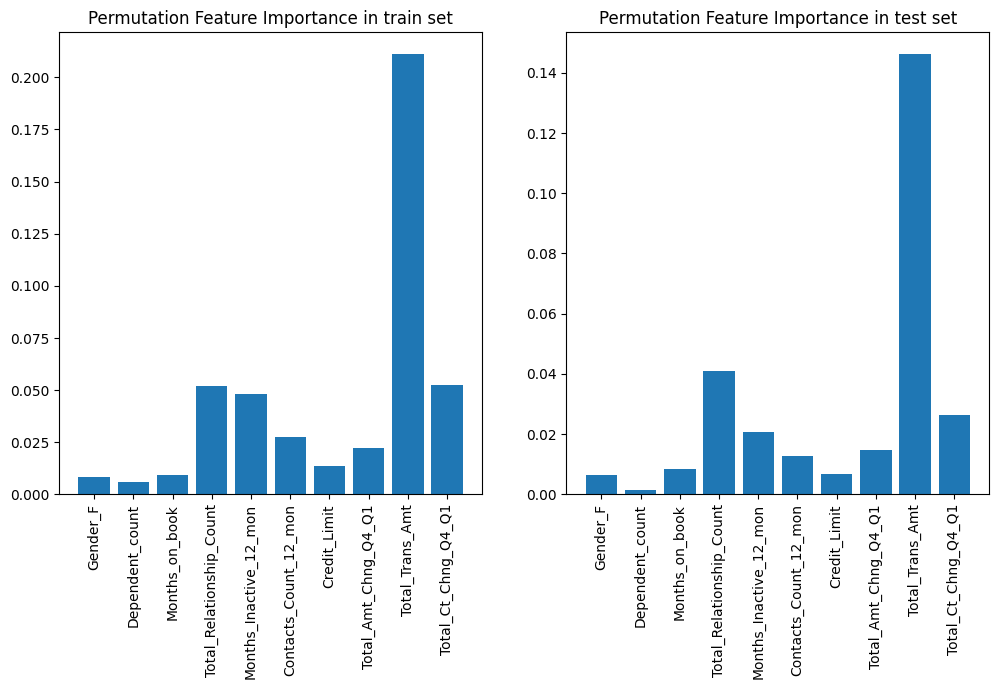

ExactExplainer explainer: 2027it [06:43,  4.90it/s]                          


Train accuracy: 0.953301956170025
Test accuracy: 0.9175715695952616
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1701
           1       0.71      0.81      0.76       325

    accuracy                           0.92      2026
   macro avg       0.84      0.87      0.85      2026
weighted avg       0.92      0.92      0.92      2026

Train permutation importance 
- Gender_F => Mean: 0.0081 ; Std: 0.0006
- Dependent_count => Mean: 0.0064 ; Std: 0.0006
- Months_on_book => Mean: 0.0092 ; Std: 0.0007
- Months_Inactive_12_mon => Mean: 0.0426 ; Std: 0.0014
- Contacts_Count_12_mon => Mean: 0.0281 ; Std: 0.0012
- Credit_Limit => Mean: 0.0154 ; Std: 0.0010
- Total_Revolving_Bal => Mean: 0.0652 ; Std: 0.0022
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0234 ; Std: 0.0010
- Total_Trans_Amt => Mean: 0.1685 ; Std: 0.0033
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0464 ; Std: 0.0017

 Test permutation importance
- Gender_F => Mean: 0.0044 ; Std: 0.0016
- Depende

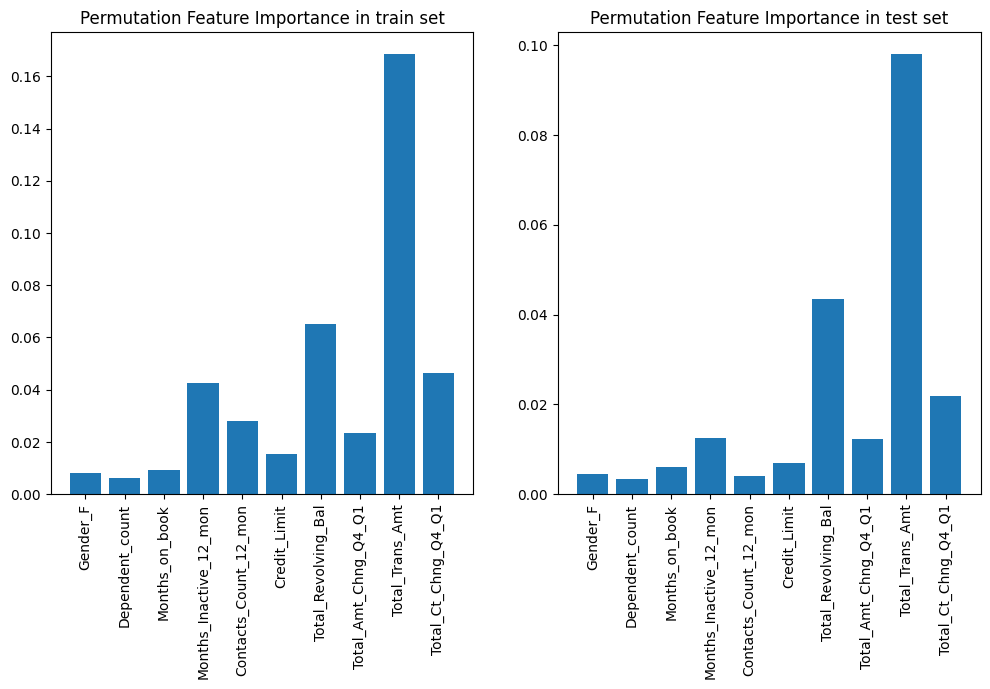

ExactExplainer explainer: 2027it [06:46,  4.87it/s]                          


Train accuracy: 0.9584497720252978
Test accuracy: 0.9234945705824285
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1701
           1       0.74      0.81      0.77       325

    accuracy                           0.92      2026
   macro avg       0.85      0.88      0.86      2026
weighted avg       0.93      0.92      0.92      2026

Train permutation importance 
- Gender_F => Mean: 0.0075 ; Std: 0.0008
- Dependent_count => Mean: 0.0056 ; Std: 0.0006
- Months_on_book => Mean: 0.0082 ; Std: 0.0004
- Total_Relationship_Count => Mean: 0.0550 ; Std: 0.0017
- Months_Inactive_12_mon => Mean: 0.0404 ; Std: 0.0013
- Contacts_Count_12_mon => Mean: 0.0176 ; Std: 0.0009
- Credit_Limit => Mean: 0.0178 ; Std: 0.0009
- Total_Revolving_Bal => Mean: 0.0651 ; Std: 0.0022
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0325 ; Std: 0.0013
- Total_Trans_Amt => Mean: 0.2261 ; Std: 0.0029

 Test permutation importance
- Gender_F => Mean: 0.0068 ; Std: 0.0026
- D

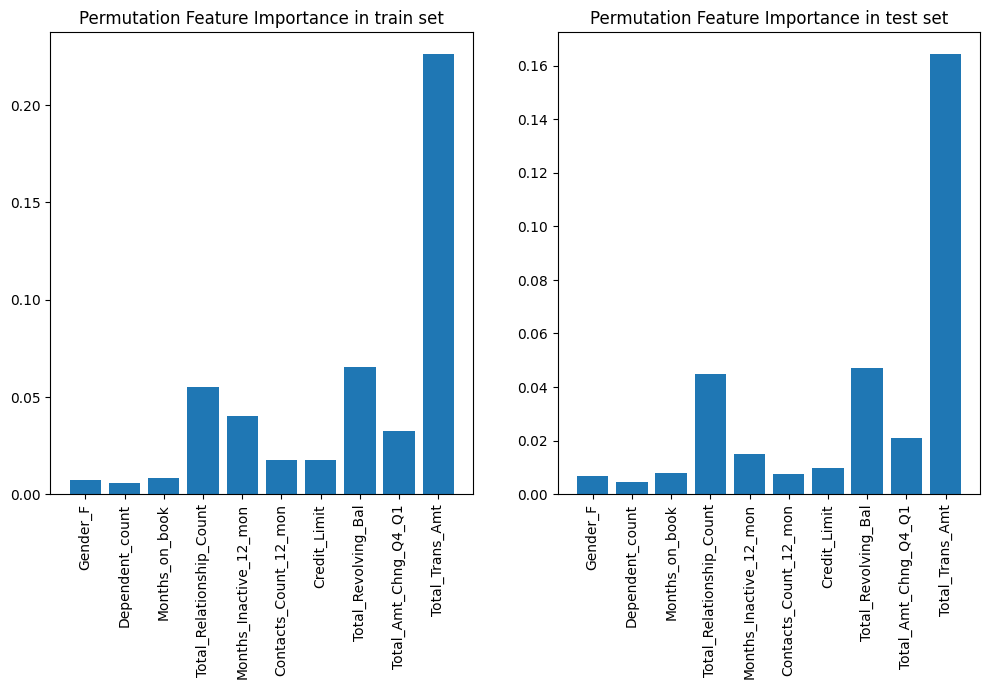

ExactExplainer explainer: 2027it [06:39,  4.95it/s]                          


Train accuracy: 0.9602147374613914
Test accuracy: 0.9294175715695953
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1701
           1       0.75      0.85      0.79       325

    accuracy                           0.93      2026
   macro avg       0.86      0.90      0.88      2026
weighted avg       0.93      0.93      0.93      2026

Train permutation importance 
- Gender_F => Mean: 0.0069 ; Std: 0.0004
- Dependent_count => Mean: 0.0063 ; Std: 0.0004
- Months_on_book => Mean: 0.0075 ; Std: 0.0004
- Total_Relationship_Count => Mean: 0.0537 ; Std: 0.0013
- Contacts_Count_12_mon => Mean: 0.0259 ; Std: 0.0011
- Credit_Limit => Mean: 0.0172 ; Std: 0.0008
- Total_Revolving_Bal => Mean: 0.0715 ; Std: 0.0017
- Total_Amt_Chng_Q4_Q1 => Mean: 0.0222 ; Std: 0.0006
- Total_Trans_Amt => Mean: 0.2066 ; Std: 0.0029
- Total_Ct_Chng_Q4_Q1 => Mean: 0.0453 ; Std: 0.0015

 Test permutation importance
- Gender_F => Mean: 0.0059 ; Std: 0.0016
- Depe

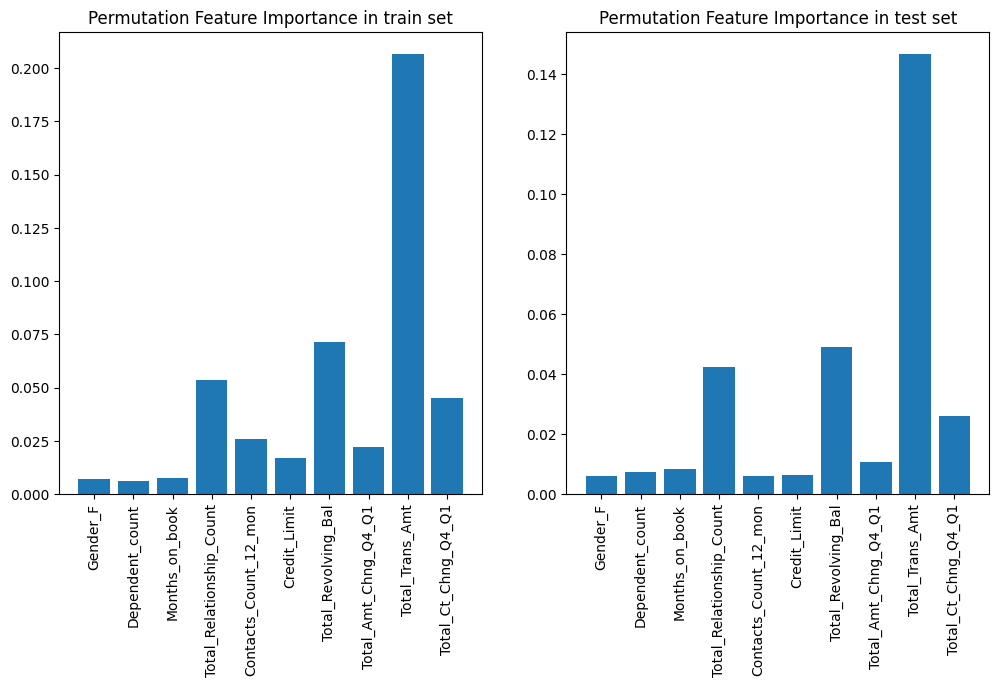

ExactExplainer explainer: 2027it [06:42,  4.92it/s]                          


In [197]:
ranks_sample1 = []
ranks_sample2 = []
feature_contribution = []

rank_sample1 = topk_df.index.get_loc(original_index_sample1)
rank_sample2 = topk_df.index.get_loc(original_index_sample2)

ranks_sample1.append(rank_sample1)
ranks_sample2.append(rank_sample2)

feature_contribution.append(calc_shap_overall_diff(ranking, rank_sample1, rank_sample2, x_test_enc, rf_model))

for feature in top_5_feat:
	dropped_x_train = x_train_enc.drop(columns=[feature])
	dropped_x_test = x_test_enc.drop(columns=[feature])

	new_ranking, new_probs, new_y_pred = fit_and_rank(rf_model, dropped_x_train, y_train, dropped_x_test, y_test, f"pictures/exp2/rem_{feature}.png")
	new_topK_df = get_topK(dropped_x_test, y_test, new_y_pred, new_ranking, new_probs, 200)

	#extract the new ranking ids and append
	rank_sample1 = new_topK_df.index.get_loc(original_index_sample1)
	rank_sample2 = new_topK_df.index.get_loc(original_index_sample2)

	ranks_sample1.append(rank_sample1)
	ranks_sample2.append(rank_sample2)

	#feature contribution
	feature_contribution.append(calc_shap_overall_diff(new_ranking, rank_sample1, rank_sample2, dropped_x_test, rf_model))


In [198]:
print(ranks_sample1)
print(ranks_sample2)

[0, 2, 2, 0, 1, 2]
[49, 60, 11, 105, 47, 23]


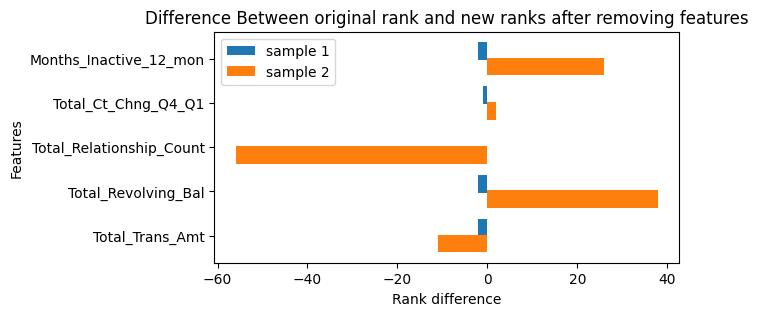

In [205]:
# Differences
differences_sample1 = [ranks_sample1[0] - rank for rank in ranks_sample1[1:]]
differences_sample2 = [ranks_sample2[0] - rank for rank in ranks_sample2[1:]]

y = np.arange(len(labels))
bar_height = 0.35 


# Plot
plt.figure(figsize=[6, 3])
plt.barh(y + bar_height/2, differences_sample1, height=0.4, label="sample 1")
plt.barh(y - bar_height/2, differences_sample2, height=0.4, label="sample 2")
plt.title('Difference Between original rank and new ranks after removing features')
plt.ylabel('Features')
plt.yticks(range(len(labels)), labels, rotation=0)
plt.xlabel('Rank difference')
plt.legend()
plt.savefig("pictures/exp1.png")
plt.show()

In [200]:
#plot the difference between the ground truth and the new ranking in bar plot
#print the feature contributions

for i in range(len(feature_contribution)):
	if i is 0: 
		print("No feature removed ")
	else :
		print("Removed feature: ", top_5_feat[i-1])
	print(feature_contribution[i], "\n")

No feature removed 
Gender_F                    0.000000
Dependent_count             0.004786
Months_on_book              0.000585
Total_Relationship_Count    0.021540
Months_Inactive_12_mon      0.035149
Contacts_Count_12_mon       0.024928
Credit_Limit                0.007551
Total_Revolving_Bal         0.235245
Total_Amt_Chng_Q4_Q1        0.000968
Total_Trans_Amt             0.002769
Total_Ct_Chng_Q4_Q1         0.039072
dtype: float64 

Removed feature:  Total_Trans_Amt
Gender_F                    0.000000
Dependent_count             0.024931
Months_on_book              0.000273
Total_Relationship_Count    0.016705
Months_Inactive_12_mon      0.057495
Contacts_Count_12_mon       0.048859
Credit_Limit                0.000538
Total_Revolving_Bal         0.314778
Total_Amt_Chng_Q4_Q1        0.001201
Total_Ct_Chng_Q4_Q1         0.006453
dtype: float64 

Removed feature:  Total_Revolving_Bal
Gender_F                    0.000000
Dependent_count             0.006649
Months_on_book         

<>:5: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
/var/folders/dz/r23r91c54xn18t6mjccp7qz40000gn/T/ipykernel_29659/4004680069.py:5: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  if i is 0:
